In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

import cv2

import os
import re


import keras
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification



c:\Users\gsevr\cudaenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
df = pd.read_csv('MELD.Raw/train_sent_emo.csv',encoding='utf-8')
df['Utterance'] = df.Utterance.str.replace('',"'")

emotions = ['negative', 'neutral', 'positive']

In [20]:
loss = 'categorical_crossentropy'
batch_size = 64
metrics = ['accuracy',
            keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None),
            keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
            ]




early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  
    patience=8,          
    verbose=4,           
    restore_best_weights=True)

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [21]:
min_size = df.Sentiment.value_counts().min()

dataframes = []

for emotion in df.Sentiment.unique():
    dataframes.append(df[df.Sentiment == emotion].sample(min_size, ignore_index=True))

df = pd.concat(dataframes, ignore_index=True)           
df = df.sample(frac=0.7, ignore_index=True)
df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,56,I'm so proud of you.,Ross,joy,positive,4,9,3,11,"0:20:40,614","0:20:41,991"
1,2105,"Monica, can I talk to you behind my menu, plea...",Phoebe,neutral,neutral,207,15,3,15,"00:15:34,058","00:15:36,017"
2,2055,I'm not! This is what I'm doing now. I've got ...,Rachel,neutral,neutral,204,7,1,4,"00:07:52,805","00:07:56,308"
3,6567,"OK, that's enough of the view. Check this out,...",Chandler,neutral,neutral,653,0,1,15,"00:15:21,712","00:15:27,675"
4,4888,"Yeah, yeah I got that.",Phoebe,neutral,neutral,499,9,6,25,"00:05:05,763","00:05:07,514"
...,...,...,...,...,...,...,...,...,...,...,...
4896,5662,"Hey, that's never gonna make it all the way ov...",Joey,anger,negative,571,15,3,8,"00:21:28,787","00:21:33,332"
4897,5830,"Hey uh, I don't mean to be presumptuous but I ...",Kyle,fear,negative,590,7,7,5,"00:08:28,633","00:08:33,803"
4898,6449,"In my defense, it was dark and he was a very p...",Chandler,anger,negative,644,7,7,4,"00:13:40,361","00:13:44,572"
4899,3804,"Joey. Joey, something feels weird and not good...",Rachel,fear,negative,383,4,8,14,"00:09:49,600","00:09:54,080"


In [22]:
face_model = tf.keras.applications.VGG16(input_shape=(48,48,3),
                                        include_top=False,
                                        weights="imagenet") 

In [23]:
# function to find biggest variable and clear memory if needed

import sys

def find_largest_global():
    largest_var_name = None
    largest_size = 0

    for var_name, var_value in globals().items():
        if not var_name.startswith('__') and not callable(var_value):
            size = sys.getsizeof(var_value)
            if size > largest_size:
                largest_size = size
                largest_var_name = var_name

    return largest_var_name, largest_size

The following produces detector embeddings without the use of a NN model.

In [7]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48, 48))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  

# Read video
folder_path = 'MELD.Raw/train_splits/'
one_face_videos = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:

                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame


                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = single_video_embeddings
        else:
            one_face_videos[file_name] = 'too many faces' 



In [8]:
df['many_faces'] = one_face_videos.values()
df['wrong_shape'] = [np.array(value).shape for value in one_face_videos.values() if value != None]

df = df[(df.many_faces != 'too many faces') & (df.wrong_shape == (1,48,48,3))]



In [24]:
split_size = int(len(df) * 0.8)


In [25]:
def preprocess(text):
    t = text.lower()
    t = re.sub('\d+',r'',t)
    t = re.sub(r'\W+',r' ',t)
    return t

lemmatizer = WordNetLemmatizer()



df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])
                .strip() for txt in df['Utterance']]

In [26]:
ohe = OneHotEncoder(categories=[['negative', 'neutral', 'positive']])
labels = ohe.fit_transform(df.Sentiment.to_numpy().reshape(-1,1)).toarray()
labels_train = labels[:split_size]
labels_val = labels[split_size:]

In [27]:
df_train = df.iloc[:split_size]
df_val = df.iloc[split_size:]

The following uses detector embeddings to fine tune the VGG16 model

In [13]:
vid_train_data = []
for video in [value for value in one_face_videos.values() if value != None and np.array(value).shape == (1,48,48,3)]:
    video = tf.reduce_mean(video,axis=0)
    vid_train_data.append(video)

vid_train = np.array(vid_train_data)[:split_size]
vid_val = np.array(vid_train_data)[split_size:]

In [14]:
#this includes transfer learning for vgg16 and makes predictions based on that.

for layer in face_model.layers[:-4]:
    layer.trainable=False


base = face_model.output

vid_pred_model = Sequential()
vid_pred_model.add(face_model)
# vid_pred_model.add(Dropout(0.2))
vid_pred_model.add(Flatten())
# vid_pred_model.add(BatchNormalization())
vid_pred_model.add(Dense(32, activation='relu'))
# vid_pred_model.add(BatchNormalization())
# vid_pred_model.add(Dropout(0.2))
# vid_pred_model.add(Dense(64,kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2()))
# vid_pred_model.add(BatchNormalization())
# vid_pred_model.add(Activation('relu'))
# vid_pred_model.add(Dropout(0.5))
vid_pred_model.add(Dense(16,activation='relu'))
# vid_pred_model.add(BatchNormalization())
vid_pred_model.add(Dense(3,activation='softmax'))

vid_pred_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



In [15]:
history_vid_pred = vid_pred_model.fit(vid_train,labels_train,epochs=10, validation_data=(vid_val,labels_val), batch_size=32, callbacks=[early_stopping_callback])

Epoch 1/10
108/108 [==============================] - 107s 990ms/step - loss: 110613.8203 - accuracy: 0.3352 - precision: 0.3138 - recall: 0.0576 - val_loss: 1.1001 - val_accuracy: 0.3337 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
108/108 [==============================] - 107s 991ms/step - loss: 1.1034 - accuracy: 0.3328 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0993 - val_accuracy: 0.3314 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
108/108 [==============================] - 113s 1s/step - loss: 1.1014 - accuracy: 0.3381 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0992 - val_accuracy: 0.3314 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
108/108 [==============================] - 107s 987ms/step - loss: 1.1026 - accuracy: 0.3381 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1012 - val_accuracy: 0.3337 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
108/108 [==========

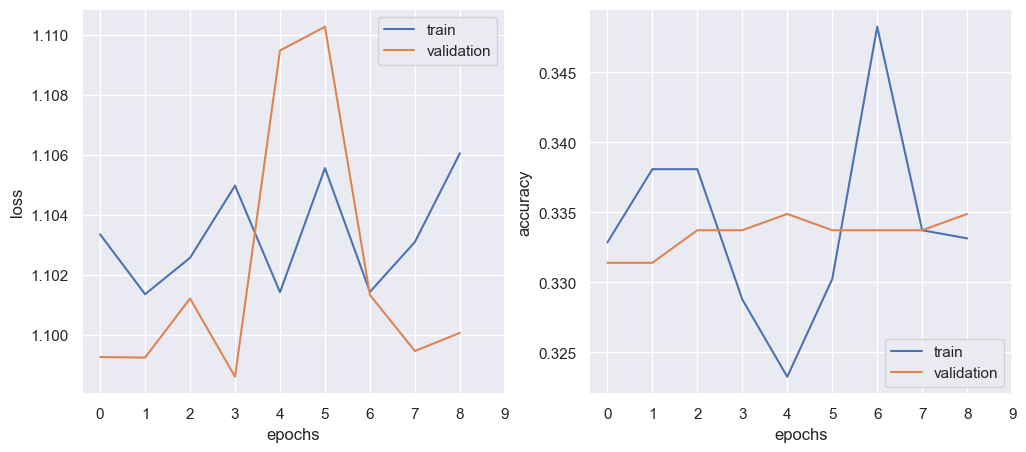

In [64]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vid_pred.history['loss'][1:])
plt.plot(history_vid_pred.history['val_loss'][1:])
plt.xticks([i for i in range(0,10)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_vid_pred.history['accuracy'][1:])
plt.plot(history_vid_pred.history['val_accuracy'][1:])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,10)])

plt.show()

In [17]:
# video predictions

video_predictions = vid_pred_model.predict(vid_val)
video_predictions


27/27 [==============================] - 4s 157ms/step


array([[0.35885283, 0.31371254, 0.3274346 ],
       [0.35885283, 0.31371254, 0.3274346 ],
       [0.35885283, 0.31371254, 0.3274346 ],
       ...,
       [0.35885283, 0.31371254, 0.3274346 ],
       [0.35885283, 0.31371254, 0.3274346 ],
       [0.35885283, 0.31371254, 0.3274346 ]], dtype=float32)

In [18]:
# this is designed to extract the embeddings from the fine tuned model

video_embedding_layers = [layer for layer in vid_pred_model.layers[:-3]]

video_embedding_model_input = vid_pred_model.input
video_embedding_model_output = video_embedding_layers[-1].output
video_embedding_model = Model(video_embedding_model_input, video_embedding_model_output)

video_embedding_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    face_embeddings = []

    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        face_embedding = video_embedding_model.predict(preprocessed_face)
        face_embeddings.append(np.squeeze(face_embedding))
        
        return face_embeddings

# Read video
folder_path = 'MELD.Raw/train_splits/'
video_embeddings = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            video_embeddings[file_name] = single_video_embeddings
        else:
            video_embeddings[file_name] = 'too many faces' 



In [28]:
from transformers import RobertaConfig
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
# model_name = 'bhadresh-savani/distilbert-base-uncased-emotion'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = RobertaConfig.from_pretrained(model_name, output_hidden_states=True)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, config=config)



All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [29]:
train_encodings = tokenizer([text for text in df_train.Utterance.values], return_tensors='tf', padding=True, truncation=True)
val_encodings = tokenizer([text for text in df_val.Utterance.values], return_tensors='tf', padding=True, truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [30]:
train_preds = model(**train_encodings)
val_preds = model(**val_encodings)

In [31]:
text_preds = softmax(val_preds[0],axis=1)

p = [emotions[i] for i in np.argmax(text_preds,axis=1)]

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(df_val.Sentiment.values, p)



array([[154, 140,  28],
       [ 34, 257,  34],
       [ 42, 124, 168]], dtype=int64)

In [32]:
accuracy_score(df_val.Sentiment.values, p)

0.5902140672782875

In [25]:
# THIS GETS EMBEDDINGS FROM DF

df_encodings = tokenizer([text for text in df.Utterance.values], return_tensors='tf', padding=True, truncation=True)
df_preds = model(**df_encodings)
df_text_preds = softmax(df_preds[0],axis=1)
text_embeddings = df_preds[1]
text_embeddings



(<tf.Tensor: shape=(4300, 54, 768), dtype=float32, numpy=
 array([[[ 1.3776219e-01, -7.9921953e-02, -4.4657392e-03, ...,
          -4.6887629e-02,  5.8683589e-02,  4.2997330e-02],
         [-9.9432781e-02,  1.5644905e-01, -1.3262859e-01, ...,
          -3.1219873e-01, -3.6366290e-01, -1.1199508e-01],
         [ 5.3043997e-01, -3.5723028e-01, -1.5432051e-01, ...,
          -2.0049730e-01, -2.6036856e-01,  5.8396149e-01],
         ...,
         [-5.0868213e-01,  5.0692499e-01,  8.0038607e-04, ...,
          -3.9926678e-01,  3.1462133e-01, -3.6372456e-01],
         [-5.0868213e-01,  5.0692499e-01,  8.0038607e-04, ...,
          -3.9926678e-01,  3.1462133e-01, -3.6372456e-01],
         [-5.0868213e-01,  5.0692499e-01,  8.0038607e-04, ...,
          -3.9926678e-01,  3.1462133e-01, -3.6372456e-01]],
 
        [[ 1.3776219e-01, -7.9921953e-02, -4.4657392e-03, ...,
          -4.6887629e-02,  5.8683589e-02,  4.2997330e-02],
         [-7.9758853e-02,  1.5075749e-01,  2.9245931e-01, ...,
        

In [26]:
text_embeddings_fn = np.mean(text_embeddings[12],axis=1)
video_embeddings_array = np.array([embedding for embedding in video_embeddings.values() if embedding != 'too many faces'])
video_embeddings_array_fn = tf.reduce_mean(video_embeddings_array, axis=4).reshape(len(video_embeddings_array),-1)

con_ten = np.concatenate([text_embeddings_fn, video_embeddings_array_fn],axis=1)


In [27]:
fusion_data = np.squeeze(np.array([con_ten],dtype=np.float16))
fusion_train = fusion_data[:split_size]
fusion_val = fusion_data[split_size:]

In [29]:
# Model for early fusion

fusion_model = Sequential()

fusion_model.add(Dense(256, activation='relu'))
# fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(128, activation='relu'))
# fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(64, activation='relu'))
# fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(len(emotions), activation='softmax'))

fusion_model.compile(optimizer='adam', loss=loss, metrics=metrics)

fusion_model_history = fusion_model.fit(fusion_train,labels_train,epochs=20, validation_data=(fusion_val,labels_val), batch_size=batch_size, callbacks=[early_stopping_callback])

Epoch 1/20
54/54 [==============================] - 12s 222ms/step - loss: 2.8344 - accuracy: 0.4201 - precision: 0.4260 - recall: 0.3033 - val_loss: 1.3769 - val_accuracy: 0.4791 - val_precision: 0.5059 - val_recall: 0.4512
Epoch 2/20
54/54 [==============================] - 11s 208ms/step - loss: 1.0159 - accuracy: 0.5422 - precision: 0.5810 - recall: 0.4442 - val_loss: 0.9359 - val_accuracy: 0.5988 - val_precision: 0.6556 - val_recall: 0.5047
Epoch 3/20
54/54 [==============================] - 12s 215ms/step - loss: 0.9521 - accuracy: 0.5706 - precision: 0.6174 - recall: 0.4724 - val_loss: 1.2077 - val_accuracy: 0.4907 - val_precision: 0.5113 - val_recall: 0.4209
Epoch 4/20
54/54 [==============================] - 11s 206ms/step - loss: 1.0714 - accuracy: 0.5622 - precision: 0.5851 - recall: 0.4907 - val_loss: 1.3026 - val_accuracy: 0.4395 - val_precision: 0.4482 - val_recall: 0.3721
Epoch 5/20
54/54 [==============================] - 11s 210ms/step - loss: 0.9783 - accuracy: 0.5695

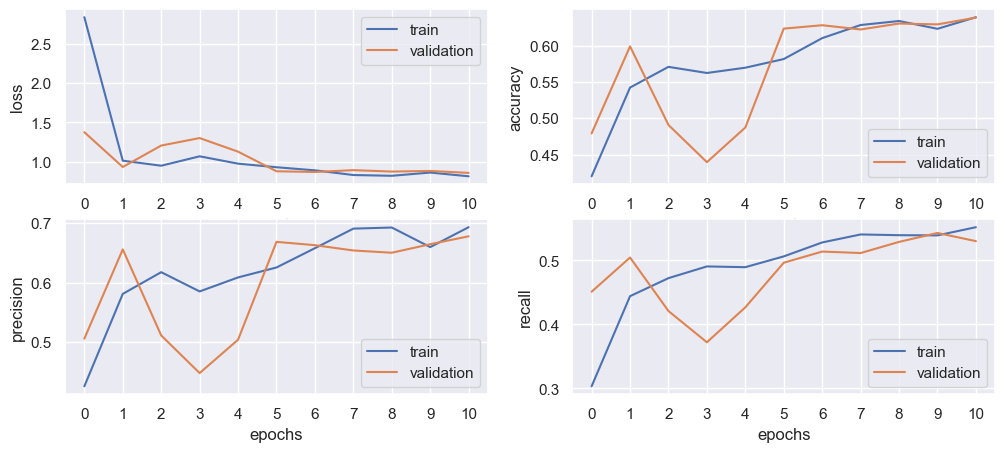

In [58]:
plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.plot(fusion_model_history.history['loss'][:11])
plt.plot(fusion_model_history.history['val_loss'][:11])
plt.xticks([i for i in range(0,11)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(2,2,2)
plt.plot(fusion_model_history.history['accuracy'][:11])
plt.plot(fusion_model_history.history['val_accuracy'][:11])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,11)])

plt.subplot(2,2,3)
plt.plot(fusion_model_history.history['precision'][:11])
plt.plot(fusion_model_history.history['val_precision'][:11])
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,11)])

plt.subplot(2,2,4)
plt.plot(fusion_model_history.history['recall'][:11])
plt.plot(fusion_model_history.history['val_recall'][:11])
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,11)])


plt.show()

In [31]:
# Late fusion

def final_preds(text_model_predictions, visual_model_predictions):
    final_predictions = []
    emotions = ['negative', 'neutral', 'positive']

    for text_pred, vis_pred in zip(text_model_predictions, visual_model_predictions):
        text_max = np.argmax(text_pred)
        vis_max = np.argmax(vis_pred)

        # Equal predictions
        if text_max == vis_max:
            final_prediction = emotions[text_max]
            print('Equal predictions')

        # Different predictions, lean towards higher confidence
        else:
            final_prediction_value = np.maximum(a := np.round(text_pred[text_max], 8), 
                                                b := np.round(vis_pred[vis_max], 8))

            try:
                print(f'Text: {a}, Visual: {b}')
                final_prediction = emotions[np.where(np.round(text_pred, 8) == final_prediction_value)[0][0]]
                print('Text wins')
            except IndexError:
                final_prediction = emotions[np.where(np.round(vis_pred, 8) == final_prediction_value)[0][0]]
                print('Visual wins')

        final_predictions.append(final_prediction)

    return final_predictions


In [32]:
late_fusion_predictions = final_preds(text_preds, video_predictions)

#TODO Confusion matrix

Text: 0.6756381392478943, Visual: 0.3588528335094452
Text wins
Text: 0.5614583492279053, Visual: 0.3588528335094452
Text wins
Text: 0.4893786907196045, Visual: 0.3588528335094452
Text wins
Text: 0.7312501668930054, Visual: 0.3588528335094452
Text wins
Text: 0.49592962861061096, Visual: 0.3588528335094452
Text wins
Text: 0.9435133337974548, Visual: 0.3588528335094452
Text wins
Text: 0.5850343704223633, Visual: 0.3588528335094452
Text wins
Text: 0.6155704259872437, Visual: 0.3588528335094452
Text wins
Text: 0.9433937072753906, Visual: 0.3588528335094452
Text wins
Text: 0.5926324725151062, Visual: 0.3588528335094452
Text wins
Text: 0.5485270619392395, Visual: 0.3588528335094452
Text wins
Text: 0.5803324580192566, Visual: 0.3588528335094452
Text wins
Equal predictions
Text: 0.6887608766555786, Visual: 0.3588528335094452
Text wins
Text: 0.5628253817558289, Visual: 0.3588528335094452
Text wins
Text: 0.6781287789344788, Visual: 0.3588528335094452
Text wins
Equal predictions
Text: 0.4958130121

In [33]:

accuracy_score(df_val.Sentiment.values, late_fusion_predictions)

0.5767441860465117

In [34]:
confusion_matrix(df_val.Sentiment.values, late_fusion_predictions)

array([[134, 112,  42],
       [ 30, 214,  43],
       [ 22, 115, 148]], dtype=int64)

In [35]:
tved_df = pd.read_csv('TVED Dataset.csv')
tved_df

,utterance,sentiment,emotion,check,By,prepro
0,"01. ""Feeling down today, everything seems a bi...",negative,Sadness,True,A,feeling down today everything seems a bit grey
1,"02. ""Just can't shake off this feeling of heav...",negative,Sadness,True,A,just cant shake off this feeling of heaviness
2,"03. ""It's like a weight in my chest that won't...",negative,Sadness,True,A,its like a weight in my chest that wont go away
3,"04. ""Trying to find some light in this darknes...",negative,Sadness,True,A,trying to find some light in this darkness bu...
4,"05. ""Feeling a bit lost and not sure how to li...",negative,Sadness,True,I,feeling a bit lost and not sure how to lift m...
...,...,...,...,...,...,...
65,"06. ""Terrified about what might happen, need t...",negative,Fear,True,M,terrified about what might happen need to sta...
66,"07. ""Fearing the worst, trying to keep a brave...",negative,Fear,True,M,fearing the worst trying to keep a brave face
67,"08. ""Feeling a knot in my stomach, scared to m...",negative,Fear,True,E,feeling a knot in my stomach scared to move f...
68,"09. ""That was really frightening, still shaking.""",negative,Fear,True,E,that was really frightening still shaking


In [36]:
# Read video
folder_path = 'Emotions dataset/Good/'
one_face_videos = {}

for idx, row in tved_df.iterrows():
    file_name = str(row['emotion']) + ' ' + row['utterance'][:2] + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = single_video_embeddings
        else:
            one_face_videos[file_name] = 'too many faces' 



In [37]:
tved_df['many_faces'] = one_face_videos.values()
tved_df['wrong_shape'] = [np.array(value).shape for value in one_face_videos.values() if value != None]

tved_df = tved_df[(tved_df.many_faces != 'too many faces') & (tved_df.wrong_shape == (1,48,48,3))]



In [38]:
tved_labels = ohe.fit_transform(tved_df.sentiment.to_numpy().reshape(-1,1)).toarray()


In [39]:
tved_vid_train_data = []
for video in [value for value in one_face_videos.values() if value != None and np.array(value).shape == (1,48,48,3)]:
    video = tf.reduce_mean(video,axis=0)
    tved_vid_train_data.append(video)

In [40]:
tved_vid_preds = vid_pred_model.predict(np.array(tved_vid_train_data))

3/3 [==============================] - 0s 108ms/step


In [41]:
p = np.argmax(tved_vid_preds,axis=1)

In [42]:
accuracy_score(np.argmax(tved_labels,axis=1),p)

0.5714285714285714

In [43]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'Emotions dataset/Good/'
video_embeddings = {}

for idx, row in tved_df.iterrows():
    file_name = str(row['emotion']) + ' ' + row['utterance'][:2] + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            video_embeddings[file_name] = single_video_embeddings
        else:
            video_embeddings[file_name] = 'too many faces' 



In [44]:
tved_encodings = tokenizer([text for text in tved_df.utterance.values], return_tensors='tf', padding=True, truncation=True)
tved_text_preds = model(**tved_encodings)
tved_text_preds = softmax(tved_text_preds[0],axis=1)
p = [emotions[i] for i in np.argmax(tved_text_preds,axis=1)]
accuracy_score(tved_df.sentiment.values, p)



0.8

In [45]:
tved_df_encodings = tokenizer([text for text in tved_df.utterance.values], return_tensors='tf', padding=True, truncation=True)
tved_df_preds = model(**tved_df_encodings)
tved_text_embeddings = tved_df_preds[1]
tved_text_embeddings

(<tf.Tensor: shape=(70, 20, 768), dtype=float32, numpy=
 array([[[ 1.37762189e-01, -7.99219534e-02, -4.46573924e-03, ...,
          -4.68876287e-02,  5.86835891e-02,  4.29973304e-02],
         [ 3.79110724e-02, -1.30037308e-01,  1.10452600e-01, ...,
          -3.41087878e-01, -5.84595084e-01,  1.10485815e-01],
         [ 2.92314142e-01, -5.71601987e-02,  3.89317982e-02, ...,
          -8.50661874e-01, -1.95080251e-01,  4.08580422e-01],
         ...,
         [-5.08682132e-01,  5.06924987e-01,  8.00386071e-04, ...,
          -3.99266779e-01,  3.14621329e-01, -3.63724560e-01],
         [-5.08682132e-01,  5.06924987e-01,  8.00386071e-04, ...,
          -3.99266779e-01,  3.14621329e-01, -3.63724560e-01],
         [-5.08682132e-01,  5.06924987e-01,  8.00386071e-04, ...,
          -3.99266779e-01,  3.14621329e-01, -3.63724560e-01]],
 
        [[ 1.37762189e-01, -7.99219534e-02, -4.46573924e-03, ...,
          -4.68876287e-02,  5.86835891e-02,  4.29973304e-02],
         [-1.05869010e-01, -6.3

In [46]:
tved_text_embeddings_fn = np.mean(tved_text_embeddings[12],axis=1)
tved_video_embeddings_array = np.array([embedding for embedding in video_embeddings.values() if embedding != 'too many faces'])
tved_video_embeddings_array_fn = tf.reduce_mean(tved_video_embeddings_array, axis=4).reshape(len(tved_video_embeddings_array),-1)

tved_con_ten = np.concatenate([tved_text_embeddings_fn, tved_video_embeddings_array_fn],axis=1)


In [47]:
tved_fusion_data = np.squeeze(np.array([tved_con_ten],dtype=np.float16))


In [48]:
tved_fusion_preds = fusion_model.predict(tved_fusion_data)


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 12ms/step


In [49]:
q = np.argmax(tved_fusion_preds,axis=1)

In [50]:
accuracy_score(np.argmax(tved_labels,axis=1), q)


0.9285714285714286

In [51]:
tved_late_fusion_predictions = final_preds(tved_text_preds, tved_vid_preds)


Equal predictions
Equal predictions
Equal predictions
Text: 0.6255610585212708, Visual: 0.3588528335094452
Text wins
Equal predictions
Text: 0.45937448740005493, Visual: 0.3588528335094452
Text wins
Equal predictions
Equal predictions
Equal predictions
Equal predictions
Text: 0.654090166091919, Visual: 0.3588528335094452
Text wins
Equal predictions
Text: 0.7181044220924377, Visual: 0.3588528335094452
Text wins
Text: 0.700660228729248, Visual: 0.3588528335094452
Text wins
Text: 0.4042772352695465, Visual: 0.3588528335094452
Text wins
Text: 0.43857648968696594, Visual: 0.3588528335094452
Text wins
Text: 0.45509618520736694, Visual: 0.3588528335094452
Text wins
Text: 0.9605651497840881, Visual: 0.3588528335094452
Text wins
Text: 0.737758219242096, Visual: 0.3588528335094452
Text wins
Text: 0.973134458065033, Visual: 0.3588528335094452
Text wins
Text: 0.4978858530521393, Visual: 0.3588528335094452
Text wins
Text: 0.5822760462760925, Visual: 0.3588528335094452
Text wins
Text: 0.787902891635

In [52]:
accuracy_score(tved_df.sentiment.values, tved_late_fusion_predictions)

0.8

In [ ]:
# save models

fusion_model.save('fusion_model.h5')
